# Time series prediction using LSTM

## Dataset
- Daily minimum temperatures in Melbourne, Australia, 1981-1990
- Units: Degrees Celcius

## Question 1

### Load the data
- load daily-minimum-temperatures-in-me.csv

In [1]:
#Load the basic libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load the data from the local copy
temp_df = pd.read_csv("daily-minimum-temperatures-in-me.csv")

In [3]:
#sanity
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null object
Temperature    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


### Print the data
- First 5 rows only

In [4]:
temp_df.head(5)

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Set index column
- Set the DataFrame index using "Date" column

In [5]:
temp_df.set_index("Date",inplace=True)

In [6]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0+ KB


## Question 2

### Check the total count of null values in the data

In [7]:
temp_df.isna().sum()

Temperature    0
dtype: int64

### Drop all the rows with null values
- use dropna() method

In [8]:
#There are no null values
temp_df.dropna(inplace=True)

In [9]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0+ KB


## Question 3

### Describe your dataframe
- use describe() method

In [10]:
temp_df.describe()
#very slight right skewed data

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


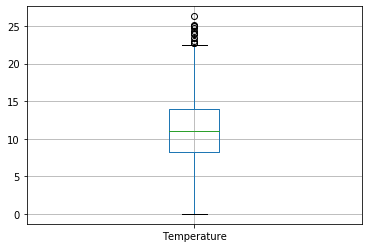

In [11]:
temp_df.boxplot()

### Plot the dataframe
- use plot() method

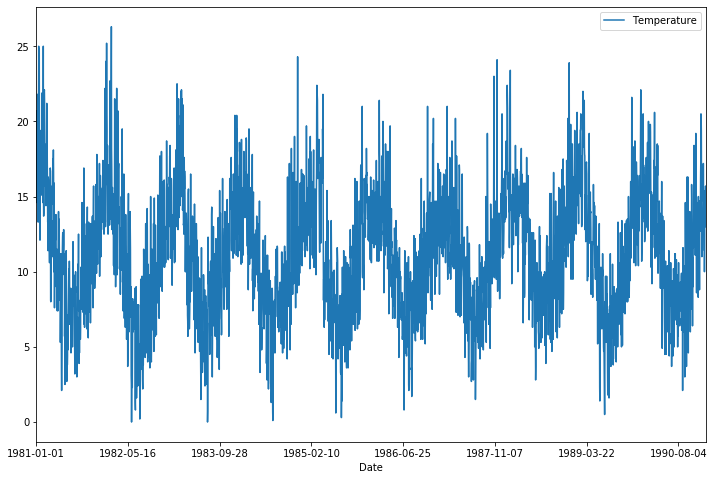

In [12]:
temp_df.plot(figsize=(12,8))

### Get representation of the distribution of data using histogram
- use hist() method

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020134B46390>]],
      dtype=object)

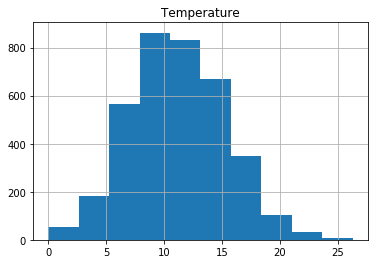

In [13]:
temp_df.hist()

### Check minimum and maximum temperature
- use min() and max() methods

In [14]:
print(f'Min Temp Value: {temp_df.min()}')

Min Temp Value: Temperature    0.0
dtype: float64


In [15]:
print(f'Max Temp Value: {temp_df.max()}')

Max Temp Value: Temperature    26.3
dtype: float64


## Question 4

### Split the dataset into training and testing
- training data: 75%
- testing data: 25%

In [16]:
#Since this is time series data we will not do a random split but pick the first 75% as training and rest as test
from sklearn.model_selection import train_test_split

In [17]:
train, test = train_test_split(temp_df,test_size=0.25,shuffle=False)

In [18]:
#sanity
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2737 entries, 1981-01-01 to 1988-06-30
Data columns (total 1 columns):
Temperature    2737 non-null float64
dtypes: float64(1)
memory usage: 42.8+ KB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913 entries, 1988-07-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    913 non-null float64
dtypes: float64(1)
memory usage: 14.3+ KB


### Normalize the data
- normalize temperature values using MinMaxScaler
- feature_range: 0-1
- fit MinMaxScaler on train data and transform it
  - use fit_transform() method
- transform test data using MinMaxScaler object
  - use transform() method

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()

In [22]:
train_sc = scaler.fit_transform(train)

In [23]:
test_sc = scaler.transform(test)

### Print scaled train and test data
- print only first 5 values

In [24]:
print(train_sc[0:5])

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]]


In [25]:
print(test_sc[0:5])

[[0.22813688]
 [0.22053232]
 [0.18631179]
 [0.19011407]
 [0.31939163]]


## Question 5

### Create sequential data
Map the temperature at a particular day 'd' to the temperature at day t
'd+n', where n is any number you define.

For example: to map temperatures of consecutive days, use d+1, i.e. lookback = 1
- Below function takes data as input and returns sequential data.
- X as features and y as labels

In [26]:
import numpy as np
def create_seq_data(data, lookback=1):
    X, y = list(), list()
  
    for day in range((len(data)-lookback)):
        X.append(data[day: day+lookback, 0])
        y.append(data[day+lookback, 0])
    return np.array(X), np.array(y)

### Use the above function to create train and test sets
- Get X_train and y_train
- Get X_test and y_test
- lookback = 1

In [27]:
X_train,y_train = create_seq_data(train_sc,lookback=1)

In [28]:
#sanity
X_train[0],y_train[0]

(array([0.78707224]), 0.6806083650190113)

In [29]:
X_test,y_test = create_seq_data(test_sc,lookback=1)

In [30]:
#Sanity
X_test[0],y_test[0]

(array([0.22813688]), 0.22053231939163498)

In [31]:
#shape of X and y now
print("X shape",X_train.shape)
print("y shape",y_train.shape)

X shape (2736, 1)
y shape (2736,)


### Reshape the data
- Reshape X_train and X_test
- use np.reshape() method
- this is to be done to make the data ready for input in model

In [32]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Print shape of data
- print shape of X_train and X_test

In [33]:
#shape of X_train and X_test now
print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)

X_train shape (2736, 1, 1)
X_test shape (912, 1, 1)


## Question 6

### Define sequential model
- initialize a Sequential model
- add an LSTM layer
  - units: 10
  - stateful: True
  - pass a `batch_input_shape` argument to your layer
  - batch_input_shape: (batch_size, look_back, 1)
    - batch_size: 1
    - look_back: 1
- add Dense layer with 1 neuron

In [34]:
#Import tf
import tensorflow as tf

In [58]:
BATCH_SIZE=1
LOOK_BACK=1

In [59]:
#Define a model with LSTM layer
tf.keras.backend.clear_session()

model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(10, stateful=True,batch_input_shape=(BATCH_SIZE, LOOK_BACK, 1)))

model.add(tf.keras.layers.Dense(1))


## Question 7

### compile your model
- loss: mean_squared_error
- optimizer: adam

In [60]:
model.compile(optimizer='adam', loss='mse')

### summarize your model
- use summary() method

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 10)                   480       
_________________________________________________________________
dense (Dense)                (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Question 8

### fit your model
- epochs: 50
- batch_size: 1

In [62]:
EPOCHS = 50


In [63]:
history = model.fit(X_train, y_train, 
          epochs=EPOCHS, 
          validation_data=(X_test, y_test), 
          batch_size=BATCH_SIZE)

Train on 2736 samples, validate on 912 samples
Epoch 1/50
2736/2736 [==============================] - 8s 3ms/sample - loss: 0.0170 - val_loss: 0.0087
Epoch 2/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0101 - val_loss: 0.0099
Epoch 3/50
2736/2736 [==============================] - 4s 2ms/sample - loss: 0.0102 - val_loss: 0.0094
Epoch 4/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0102 - val_loss: 0.0091
Epoch 5/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0100 - val_loss: 0.0090
Epoch 6/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0101 - val_loss: 0.0092
Epoch 7/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0100 - val_loss: 0.0096
Epoch 8/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0101 - val_loss: 0.0089
Epoch 9/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0101 - val_loss: 0.0092
Epoch 10/50
2736/

In [66]:
#Check the history object to see the results
history.history

{'loss': [0.016963676556792404,
  0.010110551009943413,
  0.010162288060342571,
  0.010184794040432163,
  0.010037563304974432,
  0.01006196364804056,
  0.010013561381496386,
  0.010054394266657477,
  0.010092837308701846,
  0.01001277443847463,
  0.010062524498841865,
  0.010008405242929749,
  0.009969939484124439,
  0.00993636286374783,
  0.009997112500593559,
  0.009992890663168504,
  0.009947257966105981,
  0.009942906478751751,
  0.00999363633468436,
  0.009984094801257462,
  0.00987212347570027,
  0.009905998015350798,
  0.010006474994190863,
  0.010015772073028954,
  0.009973395860229606,
  0.009985617385373683,
  0.00991942885917634,
  0.009877232660449138,
  0.009991864524632809,
  0.009949151307376915,
  0.009973097414301624,
  0.009977413187234628,
  0.009924425880692266,
  0.010011725595433788,
  0.00987483878112055,
  0.009969885339772515,
  0.009947278400733036,
  0.009876314663464506,
  0.009957653046829865,
  0.009906177482169265,
  0.009931483830892903,
  0.00987238586

## Question 9

### make predictions on train data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [67]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train,batch_size=BATCH_SIZE)


### reset model state
- if you are using stateful=True in your model then you should call reset_states every time, when you want to make consecutive model calls independent.
- use reset_states() method

In [68]:
model.reset_states()

### make predictions on test data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [69]:
testPredict = model.predict(X_test,batch_size=BATCH_SIZE)

## Question 10

### Inverse train predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [70]:
#Un-normalize the predited data
trainPredict_unscaled = scaler.inverse_transform(trainPredict)
y_train_unscaled = scaler.inverse_transform(y_train.reshape(-1,1))

In [71]:
#sanity
trainPredict_unscaled[0]

array([17.927608], dtype=float32)

In [72]:
#sanity
y_train_unscaled

array([[17.9],
       [18.8],
       [14.6],
       ...,
       [ 6.7],
       [ 9.4],
       [ 9.3]])

### Inverse test predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [73]:
testPredict_unscaled = scaler.inverse_transform(testPredict)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1))

In [74]:
#sanity
testPredict_unscaled[0]

array([6.4657845], dtype=float32)

In [75]:
#sanity
y_test_unscaled[0]

array([5.8])

### Evaluate train predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print training RMSE

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
np.sqrt(mean_squared_error(y_train_unscaled,trainPredict_unscaled))

2.6252590540411718

### Evaluate test predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print testing RMSE

In [80]:
np.sqrt(mean_squared_error(y_test_unscaled,testPredict_unscaled))

2.5403604358699425

#### Visualizing the performance


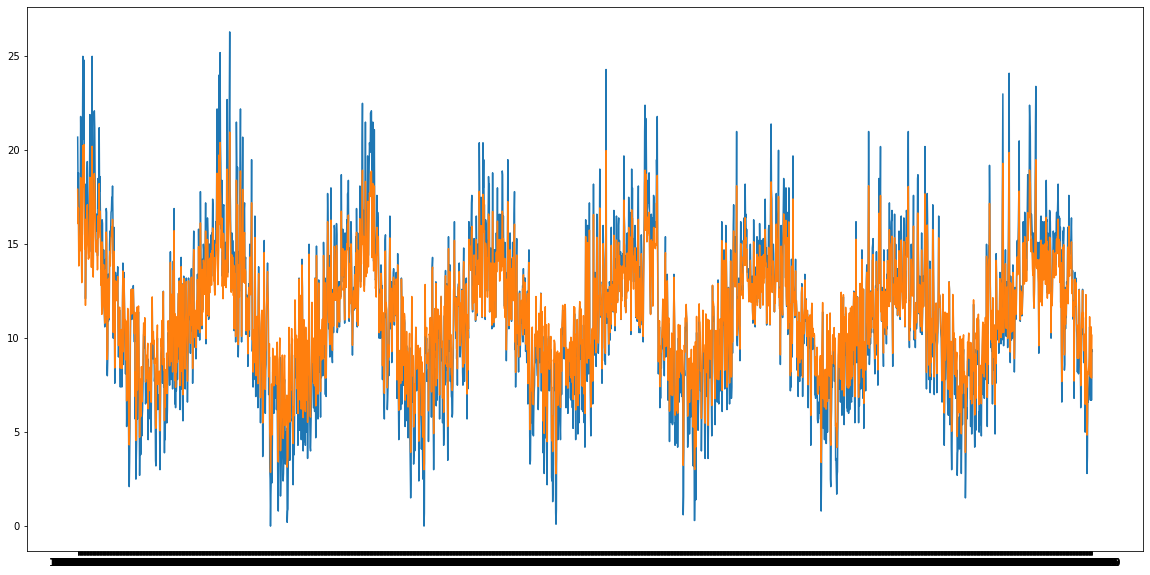

In [88]:
plt.figure(figsize=(20,10))
plt.plot(train) #Original
plt.plot(trainPredict_unscaled) #Prediction on training data
#plt.plot(testPredict)  #Prediction on test data
#plt.show()